# Testing if GRU or Prpophet is more accurate and under which data features

In [1]:
!pip install datasets
!pip install transformers
!pip install huggingface_hub
!pip install git+https://github.com/huggingface/peft.git
!pip install git+https://github.com/huggingface/accelerate.git
!pip install torch
!pip install googlesearch-python
!pip install GoogleNews
!pip install textblob
!pip install schedule
!pip install time
!pip install telebot
!pip install telethon
!pip install transformers
!pip install vadersentiment
!pip install alpha_vantage
!pip install Prophet
!pip install tensorflow
!pip install optuna
!pip install --upgrade tensorflow
!pip install newsapi-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      

In [4]:
import requests
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import schedule
import time
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from GoogleNews import GoogleNews
import yfinance as yf
import torch
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Get numeric data

In [5]:
def get_numeric_data(ticker):
    # Define the ticker symbol and time period
    period = "6mo" #must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']"
    interval = "1h"

    # Retrieve the historical market data
    data = yf.download(tickers=ticker, period=period, interval=interval)

    # Retrieve the ticker info
    ticker_info = yf.Ticker(ticker).info

    # Extract the market cap
    #market_cap = ticker_info['marketCap']

    # Calculate the moving averages
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()

    # Calculate the RSI
    delta = data['Close'].diff(1)
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = up.rolling(window=14).mean()
    roll_down = down.rolling(window=14).mean().abs()
    RS = roll_up / roll_down
    data['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    # Calculate the MACD
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Create a single dataframe called numeric_df
    numeric_df = data.select_dtypes(include=['number'])

    # Reset the index
    numeric_df.reset_index(inplace=True)

    return numeric_df

ticker = 'SPY'
numeric = get_numeric_data(ticker)
numeric.head()

[*********************100%%**********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Adj Close,Volume,MA_50,MA_200,RSI,EMA_12,EMA_26,MACD,Signal
0,2024-01-29 09:30:00-05:00,487.730011,488.269989,487.399994,487.670013,487.670013,9338325,NaN,NaN,NaN,487.670013,487.670013,0.000000,0.000000
1,2024-01-29 10:30:00-05:00,487.679993,487.919891,487.170013,487.739990,487.739990,5475949,NaN,NaN,NaN,487.680779,487.675197,0.005582,0.001116
2,2024-01-29 11:30:00-05:00,487.739990,488.480011,487.730011,488.239990,488.239990,4274476,NaN,NaN,NaN,487.766812,487.717033,0.049778,0.010849
3,2024-01-29 12:30:00-05:00,488.239990,488.589996,487.839996,488.429901,488.429901,4748834,NaN,NaN,NaN,487.868825,487.769838,0.098987,0.028476
4,2024-01-29 13:30:00-05:00,488.399994,488.910004,488.131195,488.795013,488.795013,4208077,NaN,NaN,NaN,488.011316,487.845777,0.165538,0.055889


# Get news data

How would you recomend combining news sentiment analysis data with numeric stock data to give to a GRU model for stock forcasting? I'm pertictularly focused on how the significance of the news impacts stock prices. Consideration would be matching the timing of the news and the stock data, different kinds of sentiment anlysis, etc. My current thoughts are to gather all news headlines, perform sentiment analysis on them, average the sentiments in bins of 1hr and then matching the nour bins to the 1hr ticker bins for stock data. I've included the stock data for reference.

In [ ]:
import os
import pandas as pd
from newsapi import NewsApiClient
from datetime import datetime, timedelta
def get_news():
    # Set API key and parameters
    NEWS_API_KEY = ""
    QUERY = "stock market"  # or any other query you're interested in
    START_DATE = "2024-06-27"
    END_DATE = "2024-07-25"
    LANGUAGE = "en"

    # Initialize NewsAPI client
    newsapi = NewsApiClient(api_key=NEWS_API_KEY)

    # Define a function to fetch news articles
    def fetch_news(start_date, end_date):
        articles = []
        for page in range(1, 6):  # fetch up to 5 pages of results
            response = newsapi.get_everything(
                q=QUERY,
                language=LANGUAGE,
                from_param=start_date,
                to=end_date,
                page=page
            )
            articles.extend(response["articles"])
        return articles

    # Fetch news articles
    articles = fetch_news(START_DATE, END_DATE)

    # Convert articles to a Pandas DataFrame
    df = pd.DataFrame(articles)

    # Extract relevant columns
    df = df[["title", "description", "publishedAt"]]

    # Convert publishedAt to datetime
    df["publishedAt"] = pd.to_datetime(df["publishedAt"])

    return df
#df = get_news()
#df.tail()

,title,description,publishedAt
495,Lomography announces LomoChrome '92 Sun-kissed...,<table>\n\n<tr>\n<td></td>\n</tr>\n<tr>\n<td>I...,2024-07-08 18:30:00+00:00
496,Ford Stock Stages A Comeback On F-150 Strength...,A bulk of Ford’s gains have come over the last...,2024-07-16 10:00:00+00:00
497,Can PVH Stock Rise 13% To Its Pre-Inflation Sh...,"PVH Corp's stock (NYSE: PVH), formerly Phillip...",2024-07-12 13:00:00+00:00
498,Tokenization And Onchain Transform Nvidia Stoc...,Tokenization – the representation of real-worl...,2024-07-05 12:00:00+00:00
499,"Will Higher Software Sales, Splunk Deal Drive ...",Cisco Systems Inc (NASDAQ: CSCO) currently tra...,2024-06-27 11:00:13+00:00


# Sentiment analysis


## Roberta

In [26]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

def roberta_sentiment_analysis(df):
    df = df.copy()

    # Load pre-trained RoBERTa model and tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

    # Preprocess headlines data
    encoded_headlines = df['title'].apply(lambda x: tokenizer.encode_plus(x,
                                                                          add_special_tokens=True,
                                                                          max_length=512,
                                                                          return_attention_mask=True,
                                                                          return_tensors='pt',
                                                                          truncation=True))

    # Extract the input_ids and attention_mask from the encoded headlines
    input_ids = encoded_headlines.apply(lambda x: x['input_ids'].flatten().tolist())
    attention_mask = encoded_headlines.apply(lambda x: x['attention_mask'].flatten().tolist())

    # Create new columns in the dataframe for input_ids and attention_mask
    df['input_ids'] = input_ids
    df['attention_mask'] = attention_mask

    # Create a list to store sentiment scores
    sentiment_scores = []

    # Perform sentiment analysis on each headline
    for input_id, attention_mask in zip(df['input_ids'], df['attention_mask']):
        # Create a tensor dataset and data loader
        input_id_tensor = torch.tensor([input_id])
        attention_mask_tensor = torch.tensor([attention_mask])
        dataset = torch.utils.data.TensorDataset(input_id_tensor, attention_mask_tensor)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=1)

        # Perform inference
        with torch.no_grad():
            for batch in data_loader:
                input_id, attention_mask = batch
                outputs = model(input_id, attention_mask=attention_mask)
                logits = outputs.logits
                sentiment_score = torch.softmax(logits, dim=1)[0][1].item()
                sentiment_scores.append(sentiment_score)

    # Normalize sentiment scores to be between 0 and 1
    min_score = min(sentiment_scores)
    max_score = max(sentiment_scores)
    normalized_sentiment_scores = [(score - min_score) / (max_score - min_score) for score in sentiment_scores]

    # Add normalized sentiment scores to the dataframe
    df['sentiment'] = normalized_sentiment_scores
    df.drop('attention_mask', axis=1, inplace=True)

    # Convert publishedAt to datetime and set as index
    df['publishedAt'] = pd.to_datetime(df['publishedAt'])
    df.set_index('publishedAt', inplace=True)

    # Group by hour and calculate mean sentiment score
    df_grouped = df['sentiment'].groupby(df.index.floor('H')).mean().reset_index()
    df_grouped.columns = ['hour', 'sentiment_score']

    return df_grouped

#df = get_news()
#sentiment_scores = roberta_sentiment_analysis(df)
#sentiment_scores.head()

## Vader Sentiment

In [28]:
#VaderSentiment
def vader_sentiment_analysis(df):
    df = df.copy()
    # Create a SentimentIntensityAnalyzer object
    sia = SentimentIntensityAnalyzer()

    # Apply sentiment analysis to each headline
    df['sentiment'] = df['title'].apply(lambda x: sia.polarity_scores(x)['compound'])

    # Normalize sentiment scores to be between 0 and 1
    df['sentiment'] = df['sentiment'].apply(lambda x: (x + 1) / 2)

    # Convert publishedAt to datetime and set as index
    df['publishedAt'] = pd.to_datetime(df['publishedAt'])
    df.set_index('publishedAt', inplace=True)

    # Group by hour and calculate mean sentiment score
    df_grouped = df['sentiment'].groupby(df.index.floor('H')).mean().reset_index()
    df_grouped.columns = ['hour', 'sentiment_score']

    return df_grouped

#df = get_news()
#sentiment_scores = vader_sentiment_analysis(df)
#sentiment_scores.head()

## Blob

In [29]:
from textblob import TextBlob
import pandas as pd

def blob_sentiment_analysis(df):
    df = df.copy()
    # Create a new column to store the sentiment scores
    df['sentiment'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

    # Normalize the sentiment scores to a range of 0 to 1
    min_sentiment = df['sentiment'].min()
    max_sentiment = df['sentiment'].max()
    df['sentiment_normalized'] = (df['sentiment'] - min_sentiment) / (max_sentiment - min_sentiment)

    # Convert publishedAt to datetime and set as index
    df['publishedAt'] = pd.to_datetime(df['publishedAt'])
    df.set_index('publishedAt', inplace=True)

    # Group by hour and calculate mean sentiment score
    df_grouped = df['sentiment_normalized'].groupby(df.index.floor('H')).mean().reset_index()
    df_grouped.columns = ['hour', 'sentiment_score']

    return df_grouped

#df = get_news()
#sentiment_scores = blob_sentiment_analysis(df)
#sentiment_scores.head()

## Sentiment Ensemble

In [31]:
def ensemble_sentiment_analysis(df):
    # Perform sentiment analysis using each model
    roberta_scores = roberta_sentiment_analysis(df)
    vader_scores = vader_sentiment_analysis(df)
    textblob_scores = blob_sentiment_analysis(df)

    # Create a list to store the sentiment scores from each model
    sentiment_scores = [roberta_scores, vader_scores, textblob_scores]

    # Create a DataFrame to store the ensemble sentiment scores
    ensemble_df = pd.DataFrame({'hour': roberta_scores['hour']})

    # Calculate the average sentiment score across all models for each hour
    ensemble_df['ensemble_sentiment'] = np.mean([scores['sentiment_score'] for scores in sentiment_scores], axis=0)

    # Calculate the standard deviation of sentiment scores across all models for each hour
    ensemble_df['ensemble_sentiment_std'] = np.std([scores['sentiment_score'] for scores in sentiment_scores], axis=0)

    return ensemble_df

#df = get_news()
#sentiment_scores = ensemble_sentiment_analysis(df)
#sentiment_scores.head()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,hour,ensemble_sentiment,ensemble_sentiment_std
0,2024-06-27 01:00:00+00:00,0.529009,0.032255
1,2024-06-27 05:00:00+00:00,0.538931,0.156395
2,2024-06-27 09:00:00+00:00,0.647927,0.212069
3,2024-06-27 10:00:00+00:00,0.535612,0.087718
4,2024-06-27 11:00:00+00:00,0.531273,0.050942


## Pipeline

In [35]:
def sentiment_ensemble_pipeline():
  headlines = get_news()
  sentiments = ensemble_sentiment_analysis(headlines)
  return sentiments

#sentiments = sentiment_ensemble_pipeline()
#sentiments.head()

# Concat numeric with sentiment

In [41]:
def concat_numeric_sentiments(numeric_df, sentiment_df):
    # Convert the "Datetime" column to datetime format
    numeric_df['Datetime'] = pd.to_datetime(numeric_df['Datetime'])

    # Extract the hour from the "Datetime" column
    numeric_df['hour'] = numeric_df['Datetime'].dt.floor('H')

    # Merge the two dataframes based on the hour
    combined_df = pd.merge(numeric_df, sentiment_df, left_on='hour', right_on='hour')

    # Drop the "hour" column
    combined_df = combined_df.drop('hour', axis=1)

    return combined_df

#ticker = 'SPY'
#numeric_df = get_numeric_data(ticker)
#sentiment_df = sentiment_ensemble_pipeline()
#combined_df = concat_numeric_sentiments(numeric_df, sentiment_df)
#combined_df.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume,MA_50,MA_200,RSI,EMA_12,EMA_26,MACD,Signal,ensemble_sentiment,ensemble_sentiment_std
0,2024-06-27 09:30:00-04:00,545.369995,546.960022,545.140015,546.530029,546.530029,5923547,545.620692,534.943675,66.709763,544.965054,544.843329,0.121724,-0.105766,0.591479,0.039163
1,2024-06-27 10:30:00-04:00,546.530029,546.809998,544.919983,545.289978,545.289978,3554510,545.680292,535.025275,57.012025,545.015042,544.876414,0.138628,-0.056888,0.533869,0.078885
2,2024-06-27 11:30:00-04:00,545.275024,546.020020,544.669983,545.859985,545.859985,4866462,545.721091,535.109275,62.583490,545.145033,544.949271,0.195762,-0.006358,0.498997,0.070165
3,2024-06-27 13:30:00-04:00,546.309998,546.429993,544.640015,544.770020,544.770020,2610777,545.707393,535.262650,49.606459,545.238339,545.028978,0.209361,0.081610,0.503386,0.065299
4,2024-06-27 15:30:00-04:00,545.760010,546.400024,545.179993,546.340027,546.340027,6290414,545.623893,535.414925,57.297450,545.476391,545.176576,0.299815,0.149932,0.694018,0.155461


# Data pipeline

In [42]:
def numeric_sentiment_pipeline(ticker):
  numeric_df = get_numeric_data(ticker)
  sentiment_df = sentiment_ensemble_pipeline()
  combined_df = concat_numeric_sentiments(numeric_df, sentiment_df)
  return combined_df

ticker = 'SPY'
df = numeric_sentiment_pipeline(ticker)
df.head()

[*********************100%%**********************]  1 of 1 completed
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,Datetime,Open,High,Low,Close,Adj Close,Volume,MA_50,MA_200,RSI,EMA_12,EMA_26,MACD,Signal,ensemble_sentiment,ensemble_sentiment_std
0,2024-06-27 09:30:00-04:00,545.369995,546.960022,545.140015,546.530029,546.530029,5923547,545.620692,534.943675,66.709763,544.965054,544.843329,0.121724,-0.105766,0.595452,0.033873
1,2024-06-27 10:30:00-04:00,546.530029,546.809998,544.919983,545.289978,545.289978,3554510,545.680292,535.025275,57.012025,545.015042,544.876414,0.138628,-0.056888,0.614501,0.084332
2,2024-06-27 11:30:00-04:00,545.275024,546.020020,544.669983,545.859985,545.859985,4866462,545.721091,535.109275,62.583490,545.145033,544.949271,0.195762,-0.006358,0.571681,0.054081
3,2024-06-27 13:30:00-04:00,546.309998,546.429993,544.640015,544.770020,544.770020,2610777,545.707393,535.262650,49.606459,545.238339,545.028978,0.209361,0.081610,0.579783,0.063121
4,2024-06-27 15:30:00-04:00,545.760010,546.400024,545.179993,546.340027,546.340027,6290414,545.623893,535.414925,57.297450,545.476391,545.176576,0.299815,0.149932,0.716422,0.125169


# Compare with GRU forcasting
Over the same time frame (1mo) with the same hyperparameters, the GRU model using the news sentiments had significantly better backtesting and forcasted prices than the model that just used numeric data for SPY stock

## With sentiment

In [47]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

def gru_forcast(df, future_days, num_mc_simulations):
    # Load the data
    df = df.copy()

    # Convert the Datetime column to datetime format
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # Move the Datetime column to the first position
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('Datetime')))
    df = df[cols]

    # Create a new dataframe with only the 'Close' column
    close_df = df[['High']]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_close = scaler.fit_transform(close_df)

    # Prepare the input data for the model
    seq_len = 1
    X_train = []
    y_train = []
    for i in range(seq_len, len(scaled_close)):
        X_train.append(scaled_close[i-seq_len:i])
        y_train.append(scaled_close[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    last_seq = scaled_close[-seq_len:]
    last_seq = last_seq.reshape((1, seq_len, 1))

    # Create the GRU model
    model = Sequential()
    model.add(GRU(units=1000, return_sequences=True, input_shape=(seq_len, 1)))
    model.add(Dropout(0.26))
    model.add(GRU(units=200, return_sequences=True))
    model.add(Dropout(0.26))
    model.add(GRU(units=1000, return_sequences=False))
    model.add(Dropout(0.26))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    early_stopping = EarlyStopping(monitor='loss', patience=5, min_delta=0.001)

    # Train the model
    model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, callbacks=[early_stopping])

    # Make predictions on known data
    predictions = model.predict(X_train)

    # Rescale the predictions
    predictions_rescaled = scaler.inverse_transform(predictions)

    # Plot actual and predicted prices
    plt.plot(close_df[seq_len:], label='Actual')
    plt.plot(predictions_rescaled, label='Predicted')
    plt.legend()
    plt.show()

    #future high
    future_close_prices_mc = []
    for _ in range(num_mc_simulations):
        future_close_prices = []
        last_seq_mc = scaled_close[-seq_len:]
        last_seq_mc = last_seq_mc.reshape((1, seq_len, 1))
        for i in range(future_days):
            predictions = model.predict(last_seq_mc)
            predictions_rescaled = scaler.inverse_transform(predictions)
            future_close_prices.append(predictions_rescaled[0, 0])
            predictions = predictions.reshape((1, 1, 1))  # Reshape predictions to (1, 1, 1)
            last_seq_mc = np.append(last_seq_mc[:, 1:, :], predictions, axis=1)
        future_close_prices_mc.append(future_close_prices)

    # Calculate the Monte Carlo average
    future_close_prices_mc_avg = np.mean(future_close_prices_mc, axis=0)

    # Plot forecasted prices
    plt.plot(close_df[seq_len:], label='Actual')
    plt.plot(predictions_rescaled, label='Predicted')
    plt.plot(range(len(close_df[seq_len:]), len(close_df[seq_len:])+future_days), future_close_prices_mc_avg, label='Forecasted (MC Average)')
    plt.legend()
    plt.show()

    return future_close_prices_mc_avg

ticker = 'SPY'
df = numeric_sentiment_pipeline(ticker)
future_close_prices_mc_avg = gru_forcast(df, future_days=30, num_mc_simulations=100)
print("Future High prices (MC Average):", future_close_prices_mc_avg)

## Without sentiment

START_DATE = "2024-06-27"
END_DATE = "2024-07-25"

In [50]:
ticker = 'SPY'
START_DATE = "2024-06-27"
END_DATE = "2024-07-25"

df = get_numeric_data(ticker)
select_df = df.copy()

# convert the date columns to datetime format
select_df['Datetime'] = pd.to_datetime(select_df['Datetime'])

# set the datetime column as the index
select_df.set_index('Datetime', inplace=True)

# select data between START_DATE and END_DATE
selected_df = select_df.loc[START_DATE:END_DATE].reset_index()
selected_df.head()

[*********************100%%**********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Adj Close,Volume,MA_50,MA_200,RSI,EMA_12,EMA_26,MACD,Signal
0,2024-06-27 09:30:00-04:00,545.369995,546.960022,545.140015,546.530029,546.530029,5923547,545.620692,534.943675,66.709763,544.965054,544.843329,0.121724,-0.105766
1,2024-06-27 10:30:00-04:00,546.530029,546.809998,544.919983,545.289978,545.289978,3554510,545.680292,535.025275,57.012025,545.015042,544.876414,0.138628,-0.056888
2,2024-06-27 11:30:00-04:00,545.275024,546.020020,544.669983,545.859985,545.859985,4866462,545.721091,535.109275,62.583490,545.145033,544.949271,0.195762,-0.006358
3,2024-06-27 12:30:00-04:00,545.849976,546.340027,545.612000,546.304993,546.304993,2430191,545.738992,535.191950,64.096203,545.323489,545.049695,0.273793,0.049673
4,2024-06-27 13:30:00-04:00,546.309998,546.429993,544.640015,544.770020,544.770020,2610777,545.707393,535.262650,49.606459,545.238339,545.028978,0.209361,0.081610


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


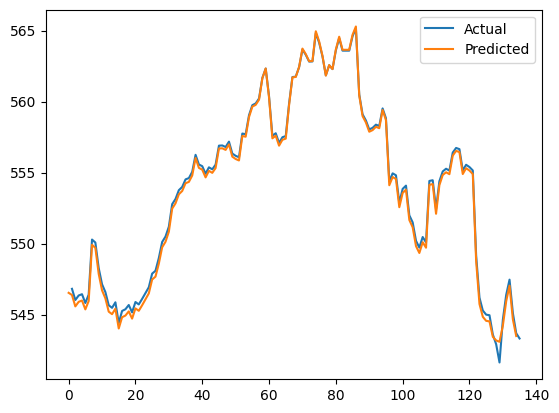

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

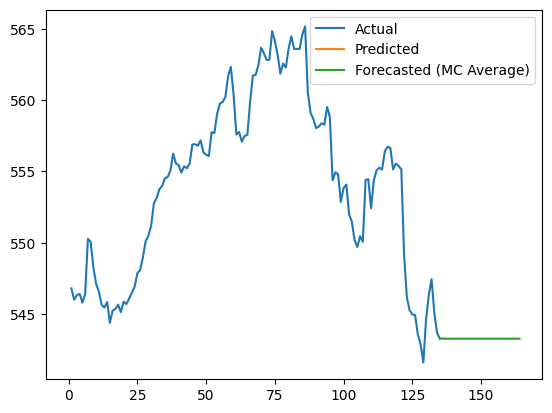

NameError: name 'seleclose_prices_mc_avg' is not defined

In [53]:
# test without the sentiment features over the same timeframe
selected_close_prices_mc_avg = gru_forcast(selected_df, future_days=30, num_mc_simulations=100)
print("Future High prices (MC Average):", selected_close_prices_mc_avg)

# Compare using Prophet

Prophet doesn't give a rats ass about the numeric data being added into it

## With sentiment

In [61]:
ticker = 'SPY'
df = numeric_sentiment_pipeline(ticker)
df.columns

[*********************100%%**********************]  1 of 1 completed
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'MA_50', 'MA_200', 'RSI', 'EMA_12', 'EMA_26', 'MACD', 'Signal',
       'ensemble_sentiment', 'ensemble_sentiment_std'],
      dtype='object')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1glkuo9v/_xrxnxnm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1glkuo9v/fq79j7_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21005', 'data', 'file=/tmp/tmp1glkuo9v/_xrxnxnm.json', 'init=/tmp/tmp1glkuo9v/fq79j7_c.json', 'output', 'file=/tmp/tmp1glkuo9v/prophet_model3yecbsjp/prophet_model-20240727171738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[544.07942768 547.00327787 547.04549942 543.34769672 543.42739292
 537.75577509 534.83185301 534.41433778 537.33818798 537.38040952]


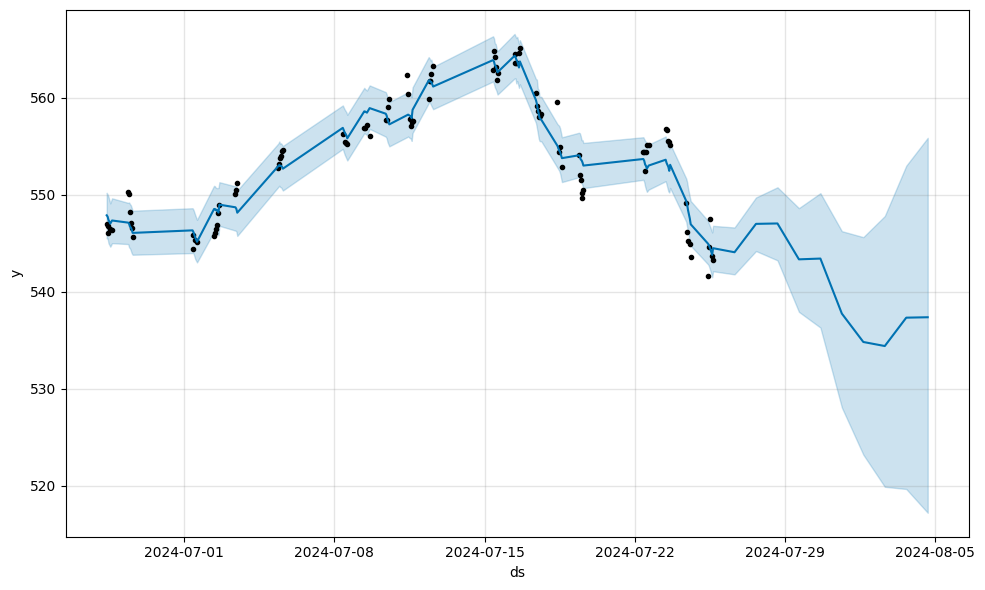

In [65]:
def whole_prophet_forecast(df, future_days):
    # Select only the necessary columns
    df = df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'MA_50', 'MA_200', 'RSI', 'EMA_12', 'EMA_26', 'MACD', 'Signal',
       'ensemble_sentiment', 'ensemble_sentiment_std']]

    # Rename the columns to match Prophet's requirements
    df = df.rename(columns={'Datetime': 'ds', 'High': 'y'})

    # Ensure the 'ds' column is of datetime type and remove timezone
    df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)

    params = {'seasonality_mode': 'additive',
              'changepoint_prior_scale': 0.03132627808654428,
              'seasonality_prior_scale': 2.0402731368344673,
              'holidays_prior_scale': 5.869231482077217
             }

    # Create a Prophet model
    model = Prophet(**params)

    # Fit the model to the data
    model.fit(df)

    # Make a forecast for the next 'future_days' days
    future = model.make_future_dataframe(periods=future_days)

    # Make predictions on the future dataframe
    forecast = model.predict(future)

    # Extract the forecasted close prices
    future_close_prices = forecast['yhat'].values[-future_days:]
    model.plot(forecast)
    return future_close_prices

ticker = 'SPY'
concat_df = numeric_sentiment_pipeline(ticker)
prophet_df = whole_prophet_forecast(df, future_days=10)
print(prophet_df)

## Without sentiment
START_DATE = "2024-06-27"
END_DATE = "2024-07-25"

In [54]:
ticker = 'SPY'
START_DATE = "2024-06-27"
END_DATE = "2024-07-25"

df = get_numeric_data(ticker)
select_df = df.copy()

# convert the date columns to datetime format
select_df['Datetime'] = pd.to_datetime(select_df['Datetime'])

# set the datetime column as the index
select_df.set_index('Datetime', inplace=True)

# select data between START_DATE and END_DATE
selected_df = select_df.loc[START_DATE:END_DATE].reset_index()
selected_df.head()

[*********************100%%**********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Adj Close,Volume,MA_50,MA_200,RSI,EMA_12,EMA_26,MACD,Signal
0,2024-06-27 09:30:00-04:00,545.369995,546.960022,545.140015,546.530029,546.530029,5923547,545.620692,534.943675,66.709763,544.965054,544.843329,0.121724,-0.105766
1,2024-06-27 10:30:00-04:00,546.530029,546.809998,544.919983,545.289978,545.289978,3554510,545.680292,535.025275,57.012025,545.015042,544.876414,0.138628,-0.056888
2,2024-06-27 11:30:00-04:00,545.275024,546.020020,544.669983,545.859985,545.859985,4866462,545.721091,535.109275,62.583490,545.145033,544.949271,0.195762,-0.006358
3,2024-06-27 12:30:00-04:00,545.849976,546.340027,545.612000,546.304993,546.304993,2430191,545.738992,535.191950,64.096203,545.323489,545.049695,0.273793,0.049673
4,2024-06-27 13:30:00-04:00,546.309998,546.429993,544.640015,544.770020,544.770020,2610777,545.707393,535.262650,49.606459,545.238339,545.028978,0.209361,0.081610


### Test just High & Datetime

[*********************100%%**********************]  1 of 1 completed
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1glkuo9v/0378sztn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1glkuo9v/hj_cu9di.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1440', 'data', 'file=/tmp/tmp1glkuo9v/0378sztn.json', 'init=/tmp/tmp1glkuo9v/hj_cu9di.json', 'output', 'file=/tmp/tmp1glkuo9v/prophet_modelkp08kxu4/prophet_model-20240727172934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Index(['ds', 'y'], dtype='object')


17:29:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[556.35972589 556.8989471  556.69693117 556.24068895 556.52560925
 557.36099261 557.53579058 557.86386962 558.40309083 558.20107489]


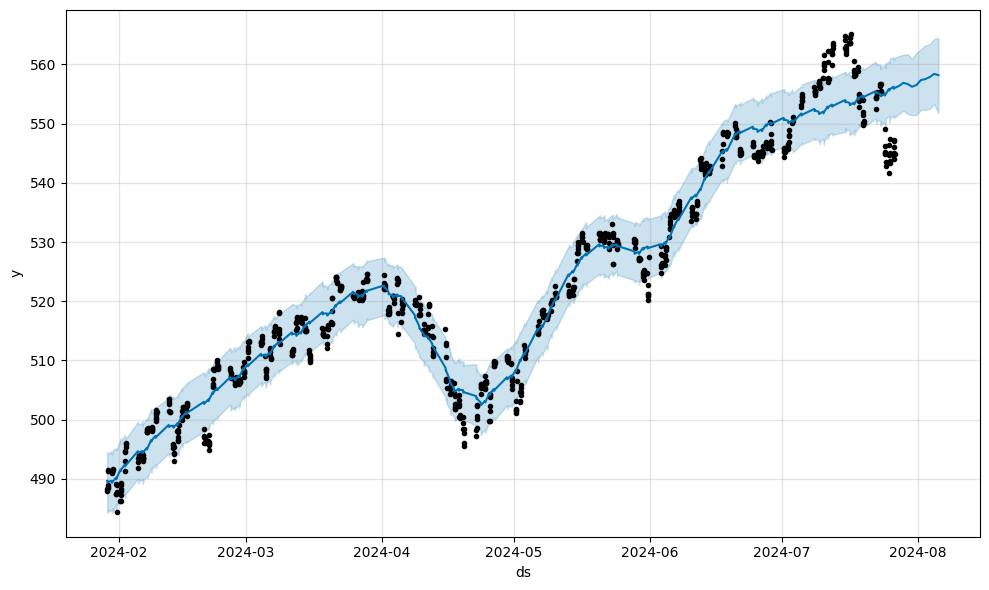

In [74]:
def selected_prophet_forecast(df, future_days):
    # Select only the necessary columns
    df = df[['Datetime', 'High']]

    # Rename the columns to match Prophet's requirements
    df = df.rename(columns={'Datetime': 'ds', 'High': 'y'})

    # Ensure the 'ds' column is of datetime type and remove timezone
    df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)

    params = {'seasonality_mode': 'additive',
              'changepoint_prior_scale': 0.03132627808654428,
              'seasonality_prior_scale': 2.0402731368344673,
              'holidays_prior_scale': 5.869231482077217
             }

    # Create a Prophet model
    model = Prophet(**params)

    # Fit the model to the data
    model.fit(df)

    # Make a forecast for the next 'future_days' days
    future = model.make_future_dataframe(periods=future_days)

    # Make predictions on the future dataframe
    forecast = model.predict(future)

    # Extract the forecasted close prices
    future_close_prices = forecast['yhat'].values[-future_days:]
    model.plot(forecast)
    return future_close_prices

long_df = get_numeric_data('SPY')
prophet_df = selected_prophet_forecast(long_df, future_days=10)
print(prophet_df)

### Test with al the numeric features

[*********************100%%**********************]  1 of 1 completed
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1glkuo9v/27c6wuya.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1glkuo9v/38_x0ibq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25571', 'data', 'file=/tmp/tmp1glkuo9v/27c6wuya.json', 'init=/tmp/tmp1glkuo9v/38_x0ibq.json', 'output', 'file=/tmp/tmp1glkuo9v/prophet_modelp0q8gj1n/prophet_model-20240727174711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[558.25000821 557.75653667 555.5664436  556.02413052 556.14160618
 556.23386197 555.99349244 559.35548917 558.86201763 556.67192456]


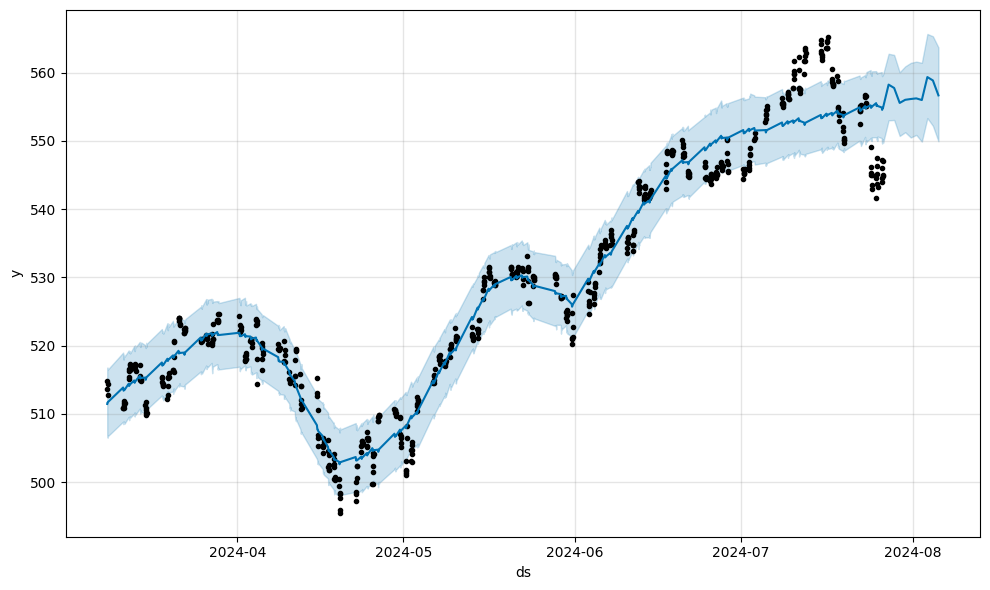

In [84]:
def whole_numeric_prophet_forecast(df, future_days):
    # Select only the necessary columns
    df = df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'MA_50', 'MA_200', 'RSI', 'EMA_12', 'EMA_26', 'MACD', 'Signal']]

    # Drop rows with missing values
    df = df.dropna()

        # Rename the columns to match Prophet's requirements
    df = df.rename(columns={'Datetime': 'ds', 'High': 'y'})

    # Ensure the 'ds' column is of datetime type and remove timezone
    df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)

    params = {'seasonality_mode': 'additive',
              'changepoint_prior_scale': 0.03132627808654428,
              'seasonality_prior_scale': 2.0402731368344673,
              'holidays_prior_scale': 5.869231482077217
             }

    # Create a Prophet model
    model = Prophet(**params)

    # Fit the model to the data
    model.fit(df)

    # Make a forecast for the next 'future_days' days
    future = model.make_future_dataframe(periods=future_days)

    # Make predictions on the future dataframe
    forecast = model.predict(future)

    # Extract the forecasted close prices
    future_close_prices = forecast['yhat'].values[-future_days:]
    model.plot(forecast)
    return future_close_prices

long_df = get_numeric_data('SPY')
prophet_df = whole_numeric_prophet_forecast(long_df, future_days=10)
print(prophet_df)


## Current Prophet with FNGU

[*********************100%%**********************]  1 of 1 completed
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1glkuo9v/jyp0u2p_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1glkuo9v/bkspvbq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9664', 'data', 'file=/tmp/tmp1glkuo9v/jyp0u2p_.json', 'init=/tmp/tmp1glkuo9v/bkspvbq3.json', 'output', 'file=/tmp/tmp1glkuo9v/prophet_modelxcmtot9b/prophet_model-20240727191601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:16:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:16:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[376.47091756 376.04285433 367.80879616 368.14402716 369.71127282
 372.06016601 372.85495117 382.73156447 382.30350124 374.06944307]


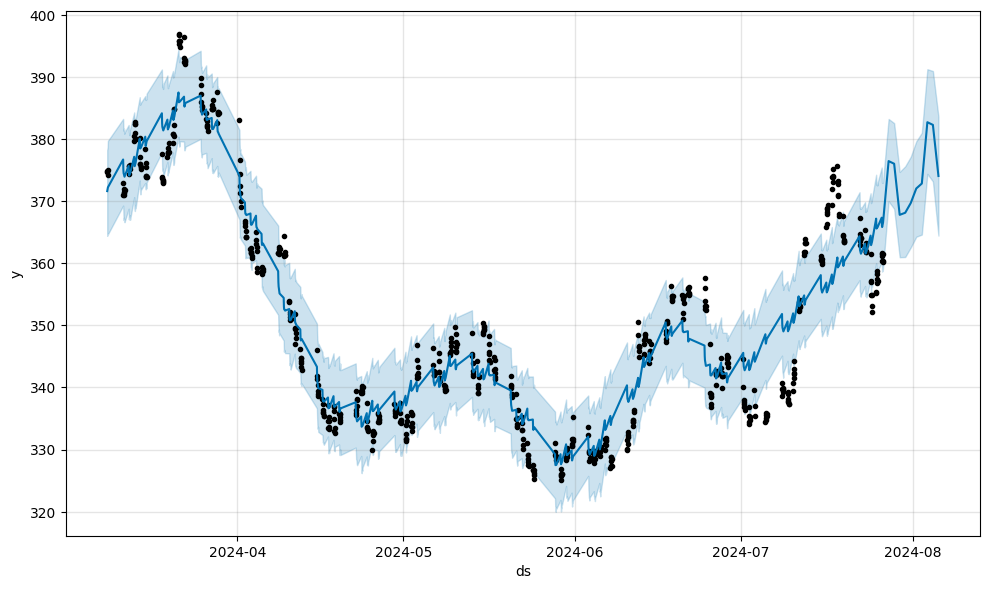

In [93]:
def fngu_prophet_forecast(df, future_days):
    # Select only the necessary columns
    df = df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'MA_50', 'MA_200', 'RSI', 'EMA_12', 'EMA_26', 'MACD', 'Signal']]

    # Drop rows with missing values
    df = df.dropna()

        # Rename the columns to match Prophet's requirements
    df = df.rename(columns={'Datetime': 'ds', 'High': 'y'})

    # Ensure the 'ds' column is of datetime type and remove timezone
    df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)

    params = {'seasonality_mode': 'additive',
              'changepoint_prior_scale': 0.03132627808654428,
              'seasonality_prior_scale': 2.0402731368344673,
              'holidays_prior_scale': 5.869231482077217
             }

    # Create a Prophet model
    model = Prophet(**params)

    # Fit the model to the data
    model.fit(df)

    # Make a forecast for the next 'future_days' days
    future = model.make_future_dataframe(periods=future_days)

    # Make predictions on the future dataframe
    forecast = model.predict(future)

    # Extract the forecasted close prices
    future_close_prices = forecast['yhat'].values[-future_days:]
    model.plot(forecast)
    return future_close_prices

fngu_df = get_numeric_data('HD')
prophet_df = fngu_prophet_forecast(fngu_df, future_days=10)
print(prophet_df)


[*********************100%%**********************]  1 of 1 completed
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


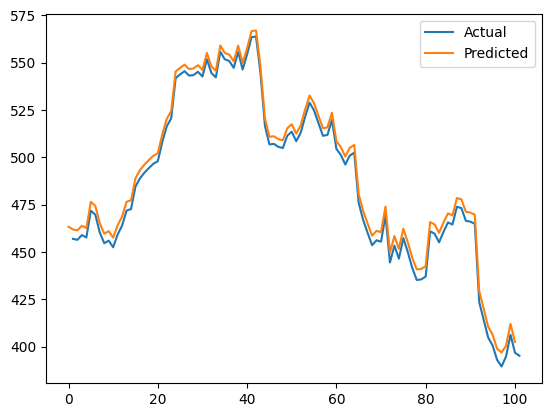

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

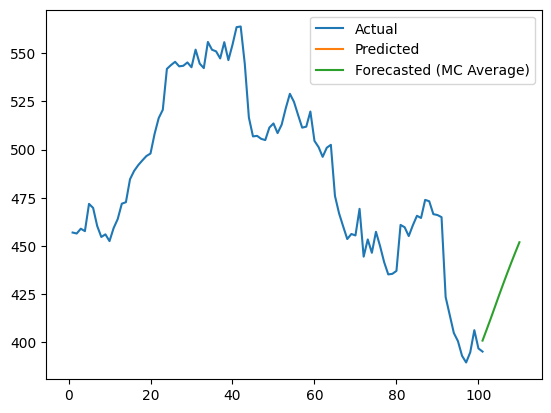

[400.93985 406.61954 412.3892  418.309   424.2759  430.10013 435.7965
 441.33734 446.72302 451.96512]


In [86]:
fngu_df = numeric_sentiment_pipeline('FNGU')
fngu_gru = gru_forcast(fngu_df, future_days=10, num_mc_simulations=100)
print(fngu_gru)